In [44]:
import seaborn as sns
import matplotlib 

import matplotlib.pyplot as plt


import math
from sys import path
path.append('..//modules')
path.append('..//dumps//reg_dmo_pdf')
import time
import pandas as pd
import psycopg2 as pg
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import create_engine, MetaData, Table
import pandas.io.sql as psql

#create a postgres engine and a pg connection
from modules.db_connector import *
print("DB connecting engine imported")


#print(matplotlib.rcParams.keys())

font = {'family' : 'Roboto', 
        'weight': '300',
        'size'   : 20}


axesfoo = {'labelweight': '300'}
#unified_colors
clr_mean = "red"
clr_mode = "black"
clr_median = "orange"

import matplotlib 
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axesfoo)

#https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)


DB connecting engine imported


In [47]:
with engine.connect() as con1:
    q = """
with foo as (
select sk_sgs_vgl_sguds.id sgs_id, sk_sgs_vgl_sguds.lokalita, 
CASE WHEN sk_sgs_vgl_sguds.dmo_id IS NULL THEN 'NO DMO' ELSE 'DMO ' || sk_sgs_vgl_sguds.dmo_id END sgs_nm_dmoid,
CASE WHEN sk_sgs_vgl_sguds.dmo_id IS NULL THEN 'SGS NOT IN DMO' ELSE 'SGS IN DMO' END sgs_in_dmo,
sk_pois_activities_tripadvisor_0723_details.id poi_id,
poi_name, 
CASE WHEN sk_pois_activities_tripadvisor_0723_details.dmo_id IS NULL THEN 'NO DMO' ELSE 'DMO ' || sk_pois_activities_tripadvisor_0723_details.dmo_id END poi_dmoid,
CASE WHEN sk_pois_activities_tripadvisor_0723_details.dmo_id IS NULL THEN 'POI NOT IN DMO' ELSE 'POI IN DMO' END poi_in_dmo,
	sk_pois_activities_tripadvisor_0723_details.poi_n_reviews , 
sk_pois_activities_tripadvisor_0723_details.poi_rating,
sk_sgs_vgl_sguds.id || '_' || sk_pois_activities_tripadvisor_0723_details.id sgs_id_poi_id
from gtlab.sk_sgs_vgl_sguds, gtlab.sk_pois_activities_tripadvisor_0723_details 
where st_distance(st_transform(sk_sgs_vgl_sguds.geom, 4326)::geography, st_transform(sk_pois_activities_tripadvisor_0723_details.geom, 4326)::geography) < 5000
)
select 'root'::text lvl, a2.from_node, a2.to_node, a2.n_sgs, a1.n_pois, a1.sum_poi_n_reviews from 
(select count(*) n_pois, sum(poi_n_reviews) sum_poi_n_reviews from (select distinct(poi_id), poi_n_reviews from foo) total_revs) a1,
(select 'SGS with POI in 5 km radius'::text from_node, 'SGS with POI in 5 km radius'::text to_node, count(*) n_sgs from (select distinct(sgs_id) from foo) distinct_sgs) a2
UNION ALL
(
select 'lvl1'::text, from_node, to_node, n_sgs, n_pois, sum_poi_n_reviews from (
select * from 
(select 'SGS with POI in 5 km radius'::text from_node, sgs_in_dmo to_node, count(*) n_sgs from (select distinct(sgs_id), sgs_in_dmo from foo) sgs_indmos group by sgs_in_dmo order by to_node) indmo
LEFT JOIN
((select 'SGS IN DMO'::text to_node, count(*) n_pois, sum(poi_n_reviews) sum_poi_n_reviews from (select distinct(poi_id), poi_n_reviews  from foo where sgs_in_dmo = 'SGS IN DMO') sgs_in_dmo_dist_poi)
UNION ALL
(select 'SGS NOT IN DMO'::text to_node, count(*) n_pois, sum(poi_n_reviews) sum_poi_n_reviews from (select distinct(poi_id), poi_n_reviews  from foo where sgs_in_dmo = 'SGS NOT IN DMO') sgs_not_in_dmo_dist_poi)) n_pois_indmo_notindmo
USING (to_node)
) level2
)
UNION ALL
(select 'lvl2'::text,  sgs_in_dmo from_node,  'SGS ID' || sgs_id to_node, 1 n_sgs, count(*) n, sum(poi_n_reviews) sum_poi_n_reviews from (select distinct(sgs_in_dmo), sgs_id, lokalita, poi_id, poi_n_reviews from foo) sgs_pois group by from_node, to_node order by from_node, to_node)
UNION ALL
(select 'lvl3'::text,  'SGS ID' || sgs_id  from_node, sgs_id || ' ' || poi_in_dmo to_node, 1 n_sgs, count(*) n_poi, sum(poi_n_reviews) sum_poi_n_reviews from foo group by from_node, to_node)
    """
    df_in = pd.read_sql(q, con=con1)
    df_in_desc = df_in.copy()
    
for i, from_node in zip(df_in.index, df_in['from_node']):
    if len(from_node.split(' ')) > 1:
        wrap_from = max([len(x) for x in from_node.split(' ')])
        df_in.loc[i, 'from_node'] = "\n".join(textwrap.wrap(from_node, wrap_from))
    
    
for i, to_node in zip(df_in.index, df_in['to_node']):
    if len(to_node.split(' ')) > 1:
        wrap_to = max([len(x) for x in to_node.split(' ')])
        df_in.loc[i, 'to_node'] = "\n".join(textwrap.wrap(to_node, wrap_to))
        


In [26]:
edges

[('SGS\nwith\nPOI in\n5 km\nradius', 'SGS\nIN\nDMO'),
 ('SGS\nwith\nPOI in\n5 km\nradius', 'SGS\nNOT\nIN\nDMO'),
 ('SGS\nIN\nDMO', 'SGS\nID100'),
 ('SGS\nIN\nDMO', 'SGS\nID102'),
 ('SGS\nIN\nDMO', 'SGS\nID104'),
 ('SGS\nIN\nDMO', 'SGS\nID110'),
 ('SGS\nIN\nDMO', 'SGS\nID111'),
 ('SGS\nIN\nDMO', 'SGS\nID112'),
 ('SGS\nIN\nDMO', 'SGS\nID113'),
 ('SGS\nIN\nDMO', 'SGS\nID116'),
 ('SGS\nIN\nDMO', 'SGS\nID119'),
 ('SGS\nIN\nDMO', 'SGS\nID12'),
 ('SGS\nIN\nDMO', 'SGS\nID120'),
 ('SGS\nIN\nDMO', 'SGS\nID121'),
 ('SGS\nIN\nDMO', 'SGS\nID123'),
 ('SGS\nIN\nDMO', 'SGS\nID124'),
 ('SGS\nIN\nDMO', 'SGS\nID125'),
 ('SGS\nIN\nDMO', 'SGS\nID13'),
 ('SGS\nIN\nDMO', 'SGS\nID132'),
 ('SGS\nIN\nDMO', 'SGS\nID136'),
 ('SGS\nIN\nDMO', 'SGS\nID139'),
 ('SGS\nIN\nDMO', 'SGS\nID140'),
 ('SGS\nIN\nDMO', 'SGS\nID141'),
 ('SGS\nIN\nDMO', 'SGS\nID147'),
 ('SGS\nIN\nDMO', 'SGS\nID15'),
 ('SGS\nIN\nDMO', 'SGS\nID151'),
 ('SGS\nIN\nDMO', 'SGS\nID152'),
 ('SGS\nIN\nDMO', 'SGS\nID154'),
 ('SGS\nIN\nDMO', 'SGS\nID156'),

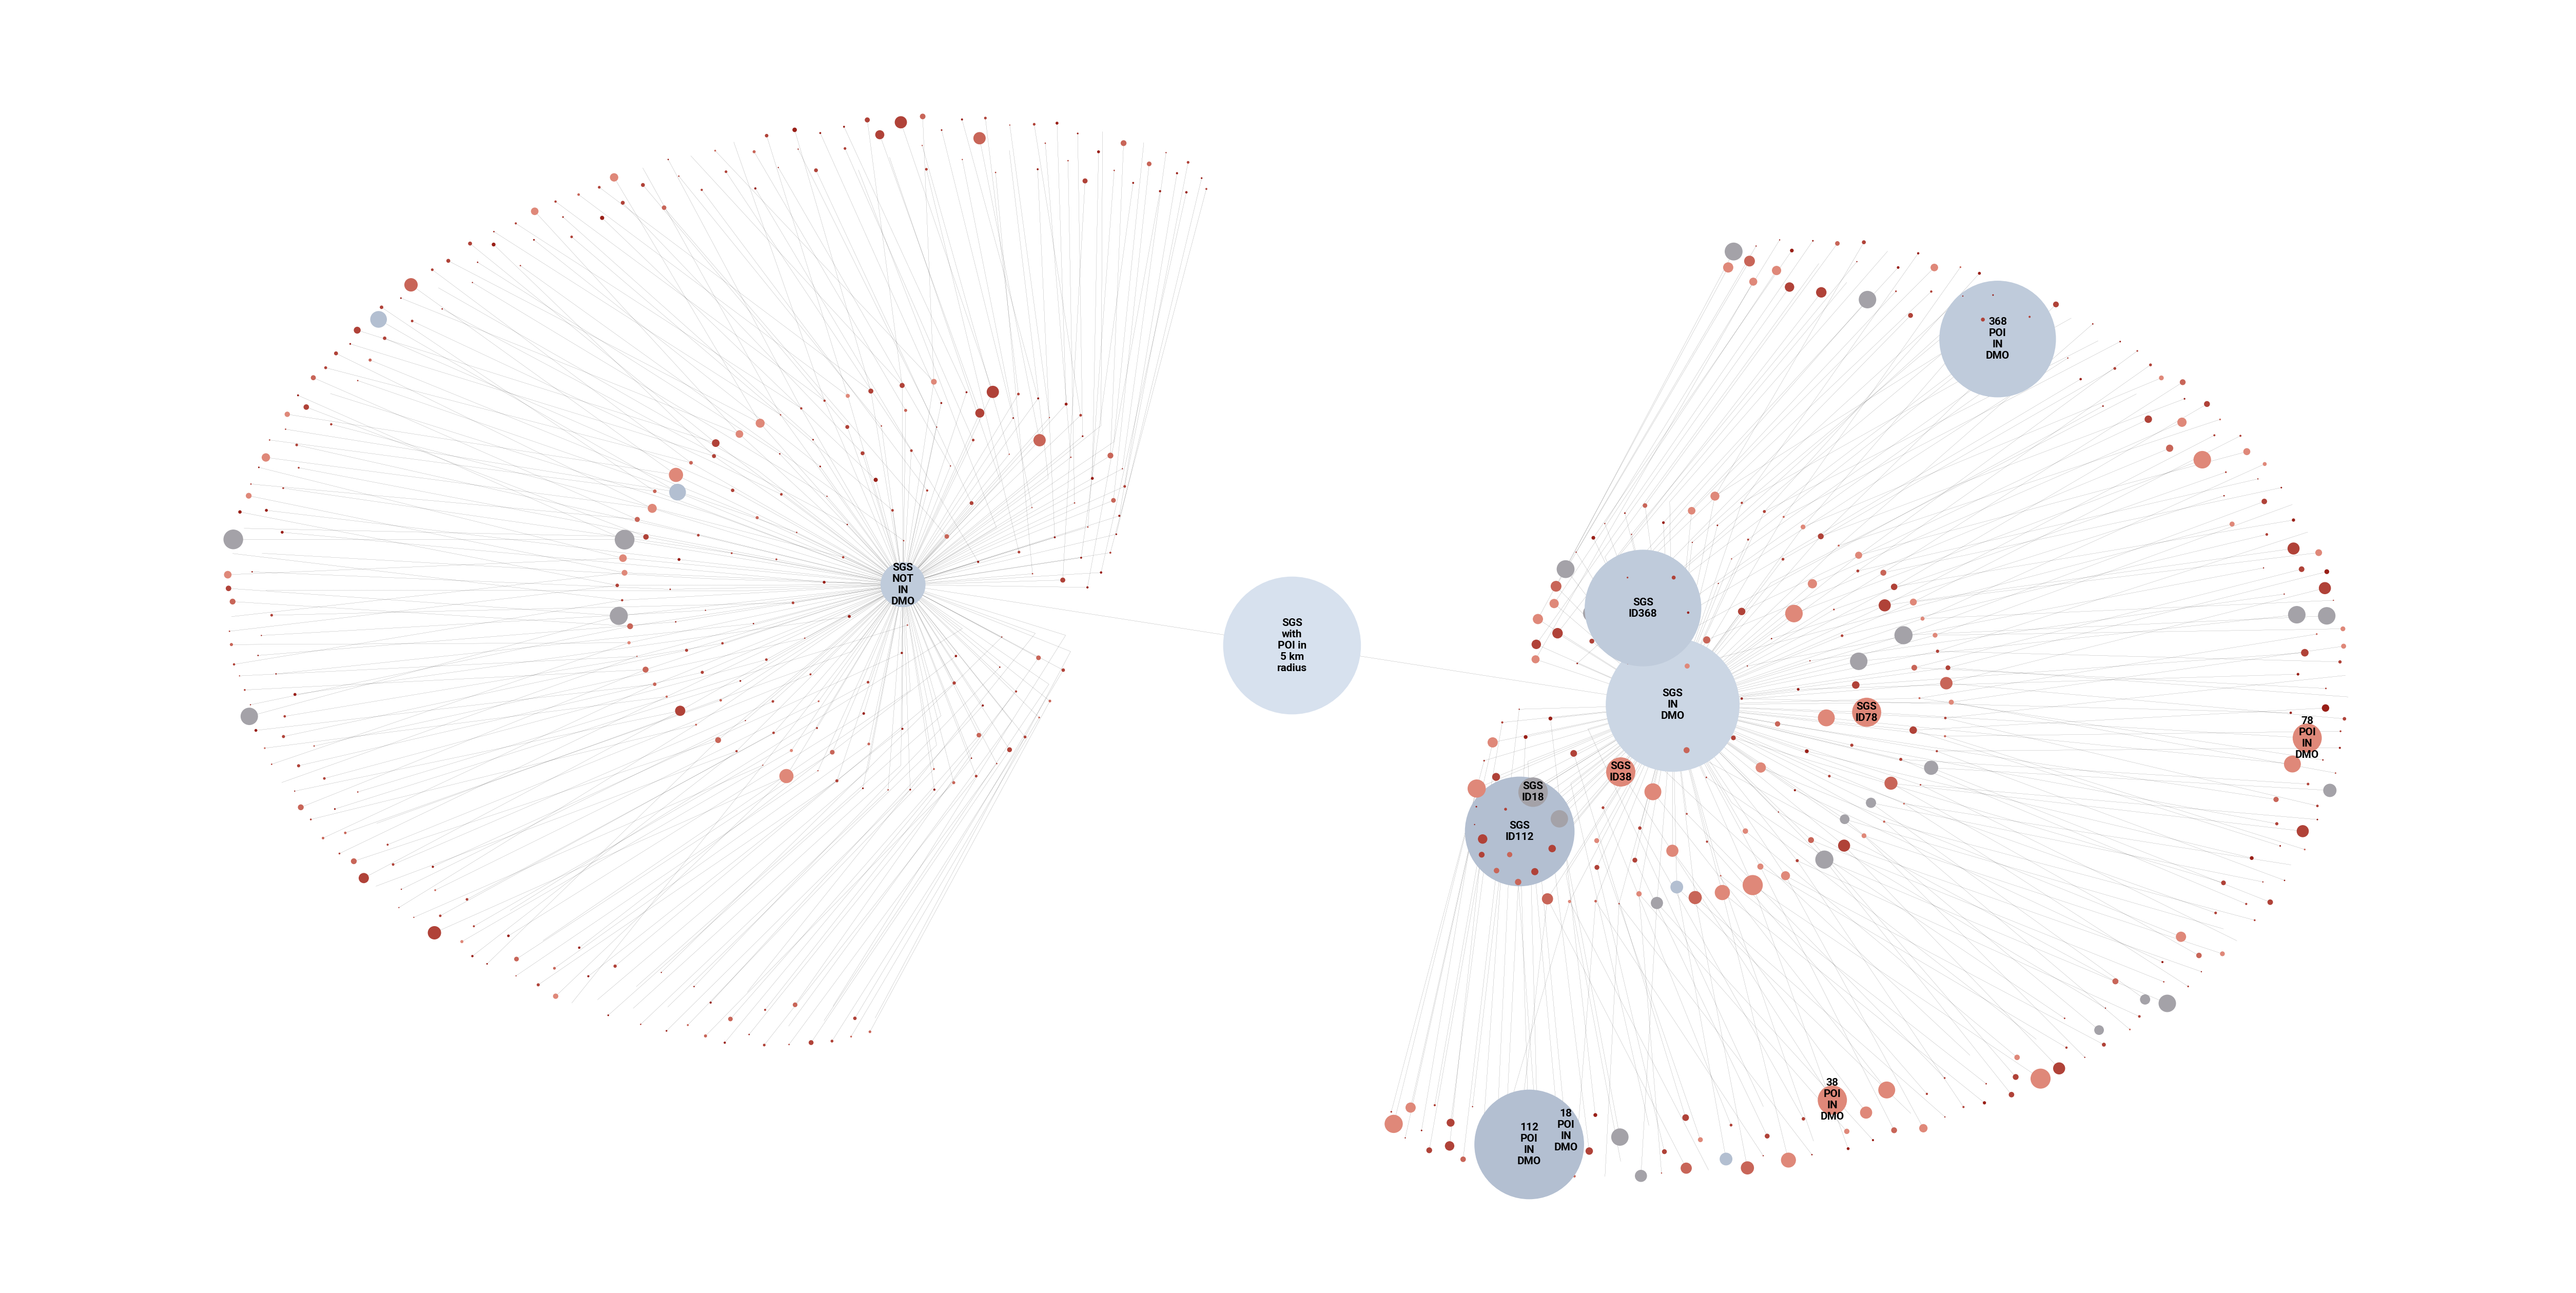

In [100]:
import pandas as pd
import networkx as nx

df_nodes = df_in.query('from_node != to_node')

G = nx.Graph() # Create an empty undirected graph (or nx.DiGraph() for a directed graph)
# Add edges from the DataFrame
edges = [(row['from_node'], row['to_node']) for index, row in df_nodes.iterrows()]
G.add_edges_from(edges)
# Add nodes from the 'source' and 'target' columns
G.add_nodes_from(df_nodes['from_node'])
G.add_nodes_from(df_nodes['to_node'])

df_nodes = pd.DataFrame(list(G.nodes))
df_nodes['nidx'] = df_nodes.index
df_nodes['to_node'] = df_nodes[0]
df_sizes = df_in.copy()
df_sizes = pd.merge(df_sizes, df_nodes, on='to_node', how='outer')
df_sizes = df_sizes.sort_values('nidx', ascending=True)
sizes_x = [x for x in df_sizes['sum_poi_n_reviews']] 

clrs = []
hex_clrs= ["#d7e1ee", "#cbd6e4", "#bfcbdb", "#b3bfd1", "#a4a2a8", "#df8879", "#c86558", "#b04238", "#991f17"]
hex_clrs.reverse()

for x in df_sizes['n_pois'].fillna(0):
    if x <= 1:
        clrs.append(hex_clrs[0])
    elif x > 1 and x <= 5:
        clrs.append(hex_clrs[1])
    elif x > 5 and x <= 10:
        clrs.append(hex_clrs[2])
    elif x > 10 and x <= 50:
        clrs.append(hex_clrs[3])
    elif x > 50 and x <= 100:
        clrs.append(hex_clrs[4])
    elif x > 100 and x <= 500:
        clrs.append(hex_clrs[5])
    elif x > 500 and x <= 1000:
        clrs.append(hex_clrs[6])
    elif x > 1000 and x <= 2000:
        clrs.append(hex_clrs[7])
    elif x > 2000:
        clrs.append(hex_clrs[8])
    
     

    
sizes_x = [x/2 for x in sizes_x]

hubs = list(df_sizes.query('sum_poi_n_reviews > 3000')['to_node'])
labels = {}    
for node in G.nodes():
    if node in hubs:
        #set the node name as the key and the label as its value 
        labels[node] = node

fig = plt.figure(figsize=(50,25)) 
pos = nx.kamada_kawai_layout(G, center=[0,0]) # Define the layout for node positioning
nx.draw(G, pos, node_size=sizes_x, with_labels=False, node_color=clrs, width=0.1)
nx.draw_networkx_labels(G,pos,labels,font_size=15, font_color='black', font_family='Roboto', font_weight='bold')
#fig.savefig("dumps/exported_figs/kamada_kawai_sgs_5KM.svg", bbox_inches="tight")

#nx.draw(G, pos, with_labels=False, node_size=sizes_x, node_color='skyblue', )

#, 


In [6]:
df_in['lvl'].unique()

array(['root', 'lvl1', 'lvl2', 'lvl3'], dtype=object)

In [18]:
df_in.query('lvl=="lvl3"')['n_pois'].quantile([0.25, .5, .75 ])

0.25    1.0
0.50    2.0
0.75    5.0
Name: n_pois, dtype: float64

In [21]:
df_in.query('lvl=="lvl3"')['n_pois'].mode()

0    1
Name: n_pois, dtype: int64

In [24]:
list(df_in.sort_values(by=['n_pois'], ascending=False)['n_pois'])


1
2
5
25
10
50
100
500
1000

[2133,
 1702,
 674,
 626,
 626,
 489,
 489,
 273,
 272,
 176,
 171,
 96,
 95,
 71,
 71,
 66,
 66,
 65,
 64,
 64,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 62,
 62,
 61,
 60,
 60,
 59,
 56,
 55,
 41,
 39,
 39,
 38,
 38,
 38,
 37,
 37,
 36,
 36,
 33,
 33,
 33,
 33,
 32,
 31,
 31,
 30,
 30,
 30,
 30,
 29,
 28,
 27,
 23,
 23,
 19,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 17,
 17,
 17,
 17,
 17,
 17,
 16,
 16,
 16,
 16,
 16,
 16,
 15,
 15,
 15,
 15,
 15,
 14,
 14,
 14,
 14,
 14,
 14,
 13,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,


In [87]:
from scipy.stats import skew, kurtosis
all_sgs_poi_n_mean = df_in_desc.query('lvl=="lvl2"')['n_pois'].mean()
all_sgs_poi_n_median = df_in_desc.query('lvl=="lvl2"')['n_pois'].median()
all_sgs_poi_n_mode = df_in_desc.query('lvl=="lvl2"')['n_pois'].mode()
skew_all_sgs_poi_n = skew(df_in_desc.query('lvl=="lvl2"')['n_pois'])

all_sgs_sum_reviews_mean = df_in_desc.query('lvl=="lvl2"')['sum_poi_n_reviews'].fillna(0).mean()
all_sgs_sum_reviews_median = df_in_desc.query('lvl=="lvl2"')['sum_poi_n_reviews'].fillna(0).median()
all_sgs_sum_reviews_mode = df_in_desc.query('lvl=="lvl2"')['sum_poi_n_reviews'].fillna(0).mode()
skew_all_sgs_sum_reviews = skew(df_in_desc.query('lvl=="lvl2"')['sum_poi_n_reviews'].fillna(0))

indmo_sgs_poi_n_mean = df_in_desc.query('lvl=="lvl2" and from_node=="SGS IN DMO"')['n_pois'].mean()
indmo_sgs_poi_n_median = df_in_desc.query('lvl=="lvl2" and from_node=="SGS IN DMO"')['n_pois'].median()
indmo_sgs_poi_n_mode = df_in_desc.query('lvl=="lvl2" and from_node=="SGS IN DMO"')['n_pois'].mode()
indmo_sgs_sum_reviews_mean = df_in_desc.query('lvl=="lvl2"  and from_node=="SGS IN DMO"')['sum_poi_n_reviews'].mean()
indmo_sgs_sum_reviews_median = df_in_desc.query('lvl=="lvl2" and from_node=="SGS IN DMO"')['sum_poi_n_reviews'].median()
indmo_sgs_sum_reviews_mode = df_in_desc.query('lvl=="lvl2"  and from_node=="SGS IN DMO"')['sum_poi_n_reviews'].mode()
skew_indmo_sgs_sum_reviews = skew(df_in_desc.query('lvl=="lvl2"  and from_node=="SGS IN DMO"')['sum_poi_n_reviews'])


notindmo_sgs_poi_n_mean = df_in_desc.query('lvl=="lvl2" and from_node=="SGS NOT IN DMO"')['n_pois'].mean()
notindmo_sgs_poi_n_median = df_in_desc.query('lvl=="lvl2" and from_node=="SGS NOT IN DMO"')['n_pois'].median()
notindmo_sgs_poi_n_mode = df_in_desc.query('lvl=="lvl2" and from_node=="SGS NOT IN DMO"')['n_pois'].mode()
notindmo_sgs_sum_reviews_mean = df_in_desc.query('lvl=="lvl2"  and from_node=="SGS NOT IN DMO"')['sum_poi_n_reviews'].mean()
notindmo_sgs_sum_reviews_median = df_in_desc.query('lvl=="lvl2" and from_node=="SGS NOT IN DMO"')['sum_poi_n_reviews'].median()
notindmo_sgs_sum_reviews_mode = df_in_desc.query('lvl=="lvl2"  and from_node=="SGS NOT IN DMO"')['sum_poi_n_reviews'].mode()
skew_notindmo_sgs_sum_reviews = skew(df_in_desc.query('lvl=="lvl2"  and from_node=="SGS NOT IN DMO"')['sum_poi_n_reviews'])

indmo_sgs_poi_n_median, indmo_sgs_sum_reviews_median


#notindmo_sgs_poi_n_median, notindmo_sgs_sum_reviews_median

(4.5, 64.0)

In [77]:


pd.pivot_table(df_in_desc.query('lvl=="lvl2"'), index='from_node',values=['n_pois', 'sum_poi_n_reviews'], aggfunc='sum')
#pd.pivot_table(df_in_desc.query('lvl=="lvl2"'), index='from_node',values=['to_node'], aggfunc='count')


,n_pois,sum_poi_n_reviews
from_node,,
SGS IN DMO,3191,137644.0
SGS NOT IN DMO,943,10578.0


In [99]:
df_in.query('lvl=="lvl2" and sum_poi_n_reviews > 1000').sort_values(by=['sum_poi_n_reviews'], ascending=False)


"112"	"Tunel Sitina"	"veľká"
"368"	"Bratislava, Okánikova ulica"	"stredná"

,lvl,from_node,to_node,n_sgs,n_pois,sum_poi_n_reviews
94,lvl2,SGS\nIN\nDMO,SGS\nID368,1,626,52928.0
8,lvl2,SGS\nIN\nDMO,SGS\nID112,1,489,46722.0
37,lvl2,SGS\nIN\nDMO,SGS\nID18,1,63,3255.0
102,lvl2,SGS\nIN\nDMO,SGS\nID38,1,38,3198.0
148,lvl2,SGS\nIN\nDMO,SGS\nID78,1,39,3172.0
18,lvl2,SGS\nIN\nDMO,SGS\nID13,1,13,1489.0
233,lvl2,SGS\nNOT\nIN\nDMO,SGS\nID3,1,64,1424.0
116,lvl2,SGS\nIN\nDMO,SGS\nID420,1,30,1203.0
118,lvl2,SGS\nIN\nDMO,SGS\nID429,1,65,1197.0
68,lvl2,SGS\nIN\nDMO,SGS\nID258,1,64,1194.0


In [101]:
3000/3198.0

0.9380863039399625

In [102]:
0.9380863039399625*14.459


13.563789868667918

In [103]:
17.861/3

5.953666666666667